<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#!pip install finta
SID = '0050.tw'
df = web.DataReader(SID,'yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(2877, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2007-12-31,61.700001,61.049999,61.450001,61.450001,2870000.0
2008-01-02,61.299999,60.000000,60.099998,60.099998,4975000.0
2008-01-03,59.349998,58.599998,59.099998,59.099998,7413000.0


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close, 1.07, 0.97, 20)['triple_barrier_signal']
df = df.join(ret)

In [6]:
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2019-08-08,80.800003,80.000000,80.050003,80.650002,5036121.0,0
2019-08-12,80.849998,80.150002,80.650002,80.599998,3168030.0,0
2019-08-13,80.150002,79.550003,80.150002,79.699997,7431519.0,0
2019-08-14,80.800003,80.300003,80.699997,80.300003,7382138.0,0
2019-08-15,79.599998,79.099998,79.199997,79.400002,15972089.0,0
2019-08-16,80.349998,79.250000,79.449997,80.349998,6158748.0,0
2019-08-19,80.900002,80.300003,80.750000,80.800003,6475352.0,0
2019-08-20,81.099998,80.800003,80.849998,81.000000,4179197.0,0
2019-08-21,81.150002,80.900002,80.949997,81.099998,6092896.0,0


(51.22531358659142, 64.3121867948783)

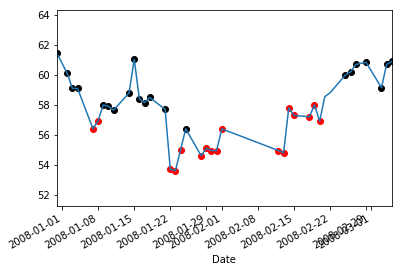

In [7]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][0:40].plot()#後20筆是前20筆的驗證
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
lb = df['Close'][0:40].mean() - 3*df['Close'][0:40].std()
ub = df['Close'][0:40].mean() + 3*df['Close'][0:40].std()
plt.ylim(lb,ub)

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    2876.000000
mean       52.505154
std        16.593634
min         0.000000
25%        40.728196
50%        53.415834
75%        64.902513
max        92.833130
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167


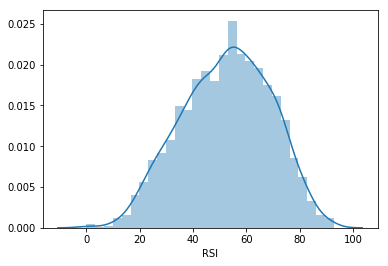

In [9]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    2864.000000
mean      -43.944648
std        31.232636
min      -100.000000
25%       -72.238984
50%       -41.048678
75%       -14.814794
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899


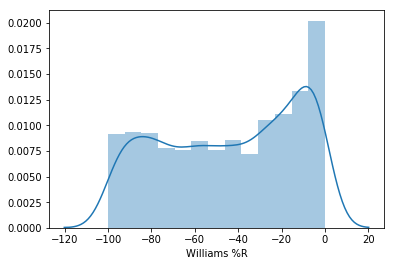

In [10]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count    2837.000000
mean       62.097558
std        12.327372
min        32.242195
25%        53.729268
50%        60.118293
75%        70.507317
max        85.841464
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317


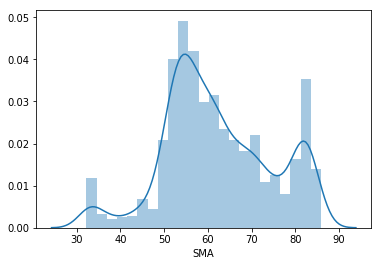

In [11]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count    2877.000000
mean       62.169258
std        12.408653
min        30.751804
25%        53.796584
50%        60.290459
75%        70.972187
max        86.800883
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283


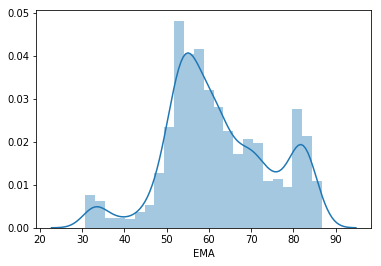

In [12]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count    2869.000000
mean       62.165520
std        12.433770
min        30.099111
25%        53.821112
50%        60.232222
75%        71.011110
max        87.264444
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556


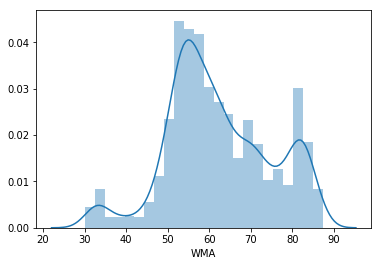

In [13]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count    2874.000000
mean       62.186256
std        12.453690
min        29.586000
25%        53.766250
50%        60.182500
75%        71.128750
max        87.854999
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999


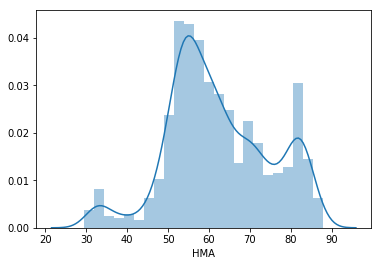

In [14]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count    2877.000000
mean       62.199432
std        12.474058
min        29.280004
25%        53.796861
50%        60.261556
75%        71.148825
max        88.240036
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691


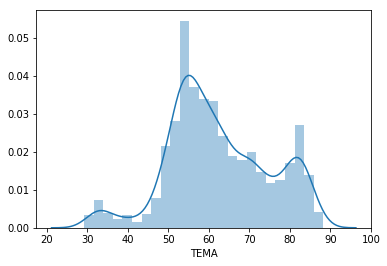

In [15]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    2876.000000
mean       11.290527
std        86.800065
min      -226.628960
25%       -56.936860
50%        22.095370
75%        82.556241
max       221.975646
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962


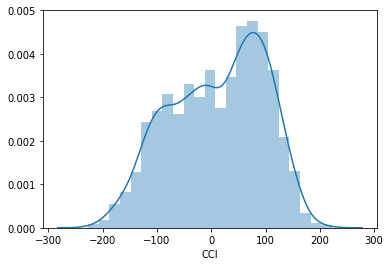

In [16]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    2868.000000
mean        5.795790
std        41.803346
min       -97.530901
25%       -25.000081
50%         5.537113
75%        36.999043
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198


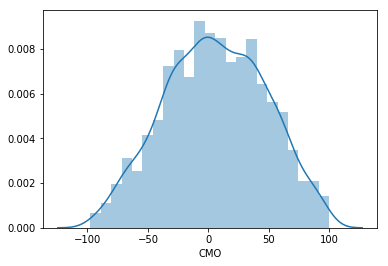

In [17]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    2877.000000
mean        0.000033
std         0.215907
min        -0.894187
25%        -0.132880
50%         0.004641
75%         0.142205
max         0.773870
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984


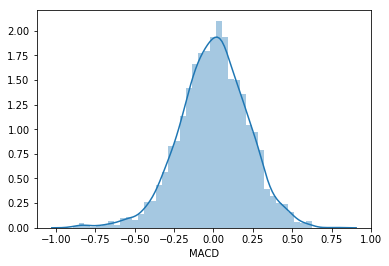

In [18]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    2877.000000
mean        0.000087
std         0.383064
min        -2.154603
25%        -0.223186
50%         0.000829
75%         0.231133
max         2.330703
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881


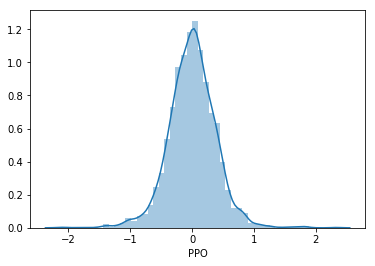

In [19]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    2865.000000
mean        0.223087
std         4.117214
min       -25.105744
25%        -1.878360
50%         0.484427
75%         2.622500
max        19.192592
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420


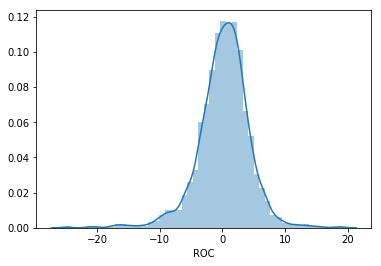

In [20]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    2.868000e+03
mean    -3.373043e+08
std      1.625415e+08
min     -8.755913e+08
25%     -3.434069e+08
50%     -3.068897e+08
75%     -2.763640e+08
max      1.163450e+08
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,-7.786882e+08
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,-7.770803e+08
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,-7.739082e+08
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,-7.673828e+08
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,-7.604778e+08


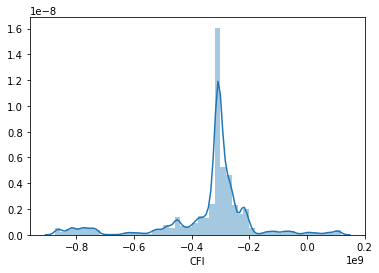

In [21]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    2794.000000
mean       -0.642832
std        22.381371
min      -127.770346
25%       -13.539123
50%         1.638485
75%        14.735095
max        70.975012
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,-7.786882e+08,11.995912
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,-7.770803e+08,3.011767
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,-7.739082e+08,5.926209
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,-7.673828e+08,21.704096
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,-7.604778e+08,24.639314


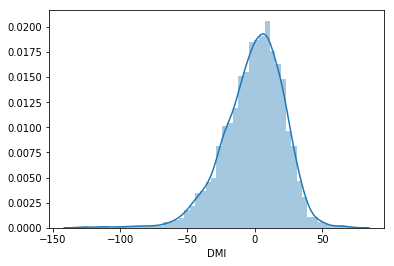

In [22]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count    2877.000000
mean       62.045070
std        12.555531
min        27.870001
25%        53.894021
50%        59.978199
75%        70.747998
max        88.400002
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,0,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,-7.786882e+08,11.995912,79.594105
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,0,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,-7.770803e+08,3.011767,79.834694
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,0,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,-7.739082e+08,5.926209,80.051225
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,0,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,-7.673828e+08,21.704096,80.309077
2019-09-06,83.550003,83.250000,83.250000,83.500000,17226303.0,0,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,-7.604778e+08,24.639314,80.713806


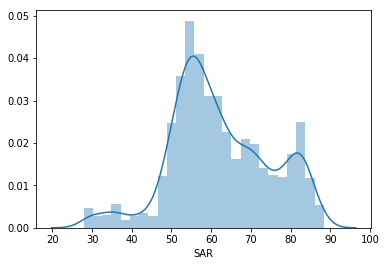

In [23]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [24]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(2877, 21)
(2794, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,65.211685,-3.448221,81.687805,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,-7.786882e+08,11.995912,79.594105,0
2019-09-03,53.807044,-27.586298,81.668293,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,-7.770803e+08,3.011767,79.834694,0
2019-09-04,63.737814,-1.612756,81.674390,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,-7.739082e+08,5.926209,80.051225,0
2019-09-05,70.324234,-5.063218,81.708536,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,-7.673828e+08,21.704096,80.309077,0
2019-09-06,73.581167,-1.265899,81.757317,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,-7.604778e+08,24.639314,80.713806,0


# 相關性分析

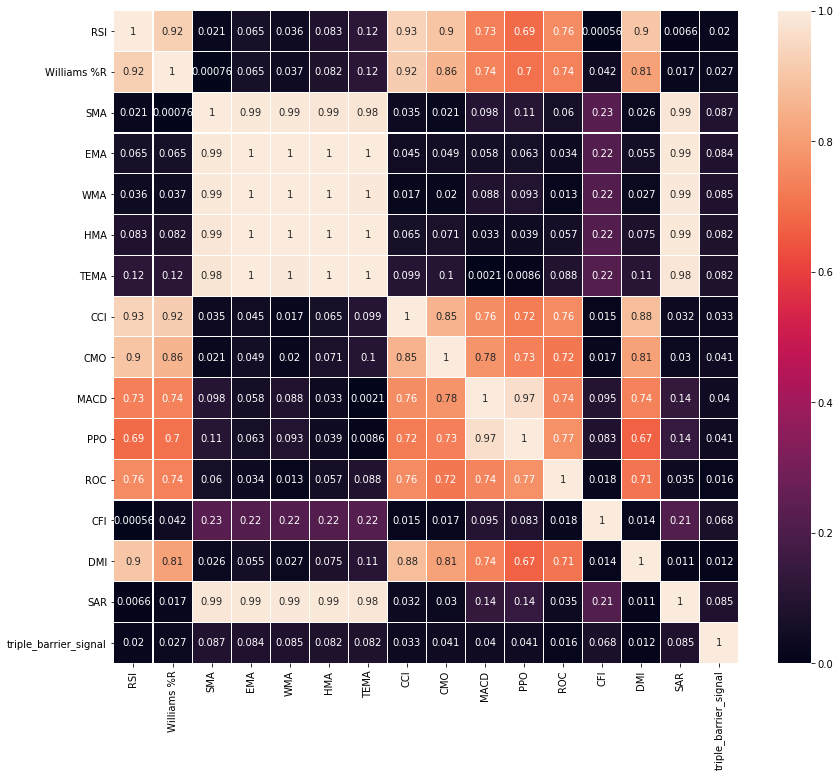

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,0.688088,0.965518,0.922505,0.895615,0.884895,0.880382,0.887433,0.825551,0.632969,0.644396,0.530102,0.611722,0.098273,0.703243,0.854520,0
2019-09-03,0.559303,0.724137,0.922141,0.896506,0.884312,0.887075,0.886568,0.721281,0.516250,0.639028,0.527639,0.617918,0.099904,0.658039,0.858495,0
2019-09-04,0.671445,0.983872,0.922255,0.900609,0.883787,0.895485,0.893530,0.773889,0.593108,0.668083,0.540967,0.617313,0.103121,0.672703,0.862072,0
2019-09-05,0.745821,0.949368,0.922892,0.906925,0.884390,0.896944,0.904649,0.872195,0.659734,0.713064,0.561514,0.628207,0.109738,0.752090,0.866332,0
2019-09-06,0.782600,0.987341,0.923802,0.913761,0.891212,0.900805,0.915394,0.863660,0.864999,0.751875,0.579110,0.636416,0.116741,0.766859,0.873018,0


In [27]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [28]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 2780/2780 [00:08<00:00, 323.96it/s]


準備完成


# check

In [29]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 2780
第一筆的index開始和結束:2008-05-08-2008-05-28
最後一筆的index開始和結束:2019-08-16-2019-09-06


# Reshape X

(圖片數量,長,寬,1張)

In [30]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(2780, 15, 15)
(2780, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [31]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(2780, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]]


Using TensorFlow backend.


(2780, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

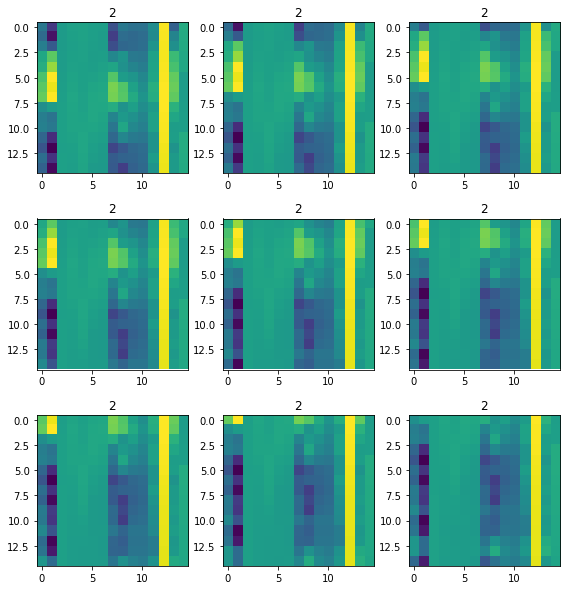

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [33]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(2740, 15, 15, 1) (2740, 3) (40, 15, 15, 1)


In [34]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2,
                                              random_state=42,
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2192, 15, 15, 1) (2192, 3) (548, 15, 15, 1) (548, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [35]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

0    1554
2    1014
1     212
dtype: int64

In [36]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

0    1217
2     814
1     161
dtype: int64

In [37]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

0    313
2    184
1     51
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [39]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))#15,15,32
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))#15,15,64
model.add(MaxPool2D(pool_size=(5,5)))# 3,3,64
model.add(Flatten())#576
model.add(Dropout(0.5))#288
model.add(Dense(128, activation='relu'))#128
model.add(Dropout(0.5))#64
model.add(Dense(32, activation='relu'))#32
model.add(Dropout(0.5))#16
model.add(Dense(nclasses, activation='softmax'))#3
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               73856     


In [40]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=50,  
                   mode='max',
                   restore_best_weights=False)#恢復最佳權重

# fit

In [42]:
history = model.fit(xtrain,ytrain,
                    batch_size = 128,
                    epochs = 500,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2192 samples, validate on 548 samples
Epoch 1/500
2192/2192 [==============================] - 2s 952us/step - loss: 1.0169 - acc: 0.4512 - val_loss: 0.9014 - val_acc: 0.5712
Epoch 2/500
2192/2192 [==============================] - 0s 120us/step - loss: 0.9472 - acc: 0.5027 - val_loss: 0.8961 - val_acc: 0.5712
Epoch 3/500
2192/2192 [==============================] - 0s 117us/step - loss: 0.9210 - acc: 0.5141 - val_loss: 0.8699 - val_acc: 0.5712
Epoch 4/500
2192/2192 [==============================] - 0s 107us/step - loss: 0.8987 - acc: 0.5214 - val_loss: 0.8582 - val_acc: 0.5785
Epoch 5/500
2192/2192 [==============================] - 0s 111us/step - loss: 0.8668 - acc: 0.5319 - val_loss: 0.8372 - val_acc: 0.5985
Epoch 6/500
2192/2192 [==============================] - 0s 117us/step - loss: 0.8744 - acc: 0.5333 - val_loss: 0.8164 - val_acc: 0.5894
Epoch 7/500
2192/2192 [==============

# 訓練過程評估

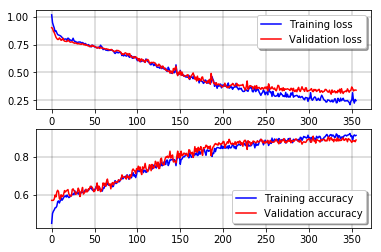

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

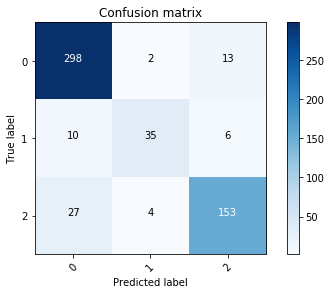

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [45]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


真實y值

In [46]:
print(yval[:5])

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# 分類報告

In [47]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.89      0.95      0.92       313
         BUY       0.85      0.69      0.76        51
        SELL       0.89      0.83      0.86       184

   micro avg       0.89      0.89      0.89       548
   macro avg       0.88      0.82      0.85       548
weighted avg       0.89      0.89      0.88       548
 samples avg       0.89      0.89      0.89       548



# plot error

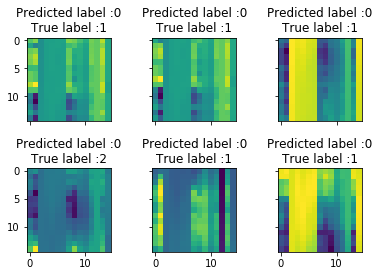

In [48]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

## 預測最後40筆

In [49]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 0~20筆

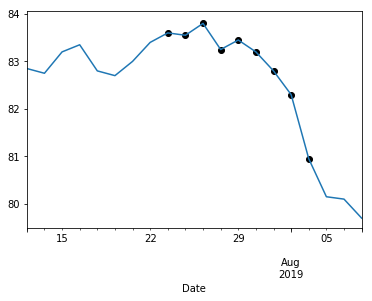

In [50]:
INDEX60 = df[-60:].index
C = web.DataReader(SID,'yahoo',start="2000-01-01")[['Close']]
C = C.loc[INDEX60,:]
C['SIGNAL'] = [np.nan for _ in range(20)] + answer #20個NAN+預測答案
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'][20:40].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 20~40筆

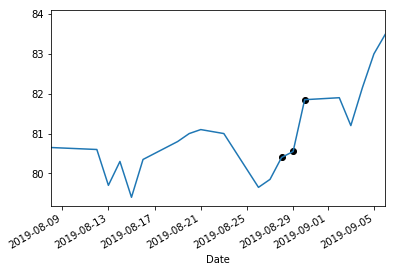

In [51]:
C['Close'][40:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 合併

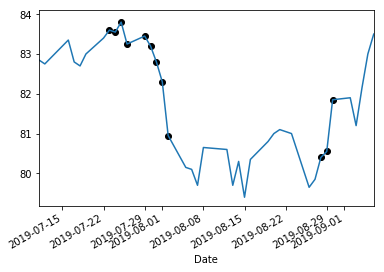

In [52]:
C['Close'][20:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 平滑版本

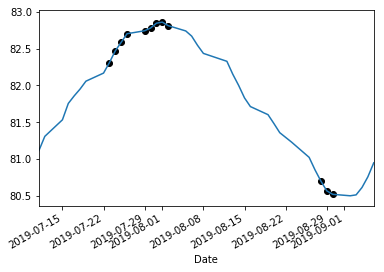

In [53]:
C_roll20 = pd.DataFrame(index=C.index)#空的dataframe index = 倒數60天股票日期
C_roll20['Close'] = C['Close'].rolling(20).mean()#收盤價做20天平滑
C_roll20['SIGNAL'] = C['SIGNAL']
buy = C_roll20[C_roll20['SIGNAL']==1]['Close']#買點
sell= C_roll20[C_roll20['SIGNAL']==2]['Close']#賣點
C_roll20['Close'][20:].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')